## Import packages

In [ ]:
import CairoMakie: activate!, Figure, Axis, save, lines!, scatter!, lines, scatter, scatterlines!, 
hlines!, vlines!, axislegend, Legend, series, series!, Theme, set_theme!, cgrad, band!, 
xlims!, ylims!, contourf!, Colorbar, hist, hist!, contour!, heatmap!, text!, rainclouds!, boxplot!, 
colgap!, rowgap!, linkyaxes!, linkxaxes!, hidedecorations!, GridLayout, density!, 
hidexdecorations!, hideydecorations!, colsize!, rowsize!, Relative, Label, Top, vspan!, hspan!
import Makie: available_gradients
import Measures: mm
import StatsBase: sample, mean, min, mode, max, std
using Distributed
import DataFrames: DataFrame, names, describe, append!, insertcols!, hcat!
import JLD: save, load
import CSV: write, read, File
import CurveFit: curve_fit, Polynomial
import Calculus: derivative
import NaNStatistics: nanmean, nanstd, nanmaximum, nanminimum, nanmax, nanmedian
import Statistics: cor
import HypothesisTests: SignedRankTest, OneSampleTTest, UnequalVarianceTTest, EqualVarianceTTest, TwoSampleTTest, CorrelationTest, pvalue
using ProgressMeter
#ENV["DATAFRAMES_ROWS"] = 5
import Plots: palette
c=palette(:default); c = [palette(:tab10)[1]; c[3]; c[2]; [c[i] for i in 4:length(c)]]; #reorder colors
#c = [c[1]; c[3]; c[2]; [c[i] for i in 4:length(c)]]; #reorder colors
#c=palette(:tab10); c = [c[1]; c[3]; c[4];c[5]; c[2]; [c[i] for i in 6:length(c)]]; #reorder colors
activate!() #activates the Makie backend
set_theme!(Theme(
    #fontsize =20,
    palette  = (color = cgrad(c,length(c)),),
    Lines    = (cycle = [:color],), 
    band     = (cycle = [:color],),
    hlines   = (cycle = [:color],),
    vlines   = (cycle = [:color],),
    scatter  = (cycle = [:color],),
    scatterlines = (cycle = [:color],),
    series   = (cycle = [:color],),
    colormap = cgrad(:default),   #sunset,    # CMRmap  gnuplot magma plasma   thermal   linear_bmy_10_95_c78_n256 linear_bmy_10_95_c71_n256
    #Axis=(yticklabelsize=18, xticklabelsize=18,xlabelsize=20,ylabelsize=20),
    #Axis=(titlesize=24,),
    ))

In [2]:
findnearest(t, A::AbstractArray) = findmin(abs.(A.-t))[2];
findnearest(vec::AbstractArray, A::AbstractArray) = findnearest.(vec, Ref(A));

nanlength(x::AbstractArray) = sum(.~isnan.(x));
nanse(x::AbstractArray) = nanstd(x) / sqrt(nanlength(x));

function get_rt_cor(choices_vec, rts_vec)  
    ## get RT in correct choices
    rt_cor = deepcopy(rts_vec);
    rt_cor[choices_vec .== 0] .= NaN;
    return rt_cor
end

function get_rt_err(choices_vec, rts_vec)  
    ## get RT in error choices
    rt_err = deepcopy(rts_vec);
    rt_err[choices_vec .== 1] .= NaN;
    return rt_err
end

function join_df_by_rate(df_rawdata, ids, cond_rate)
    ## join data by condition rate (65/35 or 50/50); both gain and loss trials are included, as they did not show significant differences
    df_group = DataFrame();
    df_status_cond = df_rawdata[(df_rawdata.cond_rate .== cond_rate) .& (df_rawdata.status .== 1), :];
    for id in ids ## go over ids of participants; combine gain/loss per person
        df = df_status_cond[(df_status_cond.id .== id), :];
        if size(df)[1] == 0
            continue
        elseif size(df)[1] == 1
            append!(df_group, df[:, [:id, :status, :cond_rate, :cond_gl, :error, :reward_mean, 
            :rt_mean, :rtcor_mean, :rterr_mean, :ratio_cw, :GABA_rest, :GABA_task, :ratioGABA_taskrest, :EI_rest, :EI_task]]);
        else
            df_join = DataFrame(
                id = id,
                status      = 1,
                cond_rate   = cond_rate,
                cond_gl     = "all",
                error       = 1-nanmean(vcat(df.choices_vec...)),
                reward_mean =   nanmean(vcat(df.rewards_vec...)),
                rt_mean     =   nanmean(vcat(df.rts_vec...    )),
                rtcor_mean  =   nanmean(vcat(df.rtcor_vec...  )),
                rterr_mean  =   nanmean(vcat(df.rterr_vec...  )),
                ratio_cw    =   NaN,
                GABA_rest   =   nanmean(df.GABA_rest),
                GABA_task   =   nanmean(df.GABA_task),
                EI_rest     =   nanmean(df.EI_rest  ),
                EI_task     =   nanmean(df.EI_task  )
            );
            df_join.ratio_cw = df_join.rtcor_mean ./ df_join.rterr_mean;
            df_join.ratioGABA_taskrest = df_join.GABA_task ./ df_join.GABA_rest;
            append!(df_group, df_join);
        end
    end
    return df_group
end

function regr_coef(x, y)
    ## calculate regression coefficients for x and y; x is the independent variable, y is the dependent variable
    x = x[.~isnan.(y)];
    y = y[.~isnan.(y)];
    r = cor(x, y);
    p = pvalue(CorrelationTest(x, y));

    b = r*std(y)/std(x);
    a = nanmean(y) - b*nanmean(x);
    return r, p, a, b
end

function plot_ratio_cw_regression!(pl, df, fit_power, cond_rate, subplot, xlims)
    ## plot regression of RTc/RTw ratio vs. error; df is the DataFrame with the data, fit_power is the power of the polynomial fit
    marker_z = marker_z_df(df);
    er = df.error[.~isnan.(df.ratio_cw), :];
    ratio = df.ratio_cw[.~isnan.(df.ratio_cw), :];
    marker_z = marker_z[.~isnan.(df.ratio_cw), :];
    ms = 8 * marker_z ./ nanmaximum(marker_z); ms[isnan.(ms)] .= 5;
    cor_cw, pcor_cw, acw, bcw = regr_coef(er, ratio);
    fit = curve_fit(Polynomial, er, ratio[:], fit_power)
    x_fit = sort(er[:]); ratio_fit = fit.(x_fit); 
    pl=hline!([1], c=:grey, lw=2, ls=:dash, label="", subplot=subplot)
    pl = scatter!(er, ratio, ylabel="RT⁺ / RT⁻", title="RT⁺/RT⁻(error) at $(cond_rate)/$(100-cond_rate)", subplot=subplot, legend=:bottomright,
    marker_z = marker_z, ms=ms, color=color, rightmargin=1mm, xlims=xlims, label="")
    pl = plot!(x_fit, acw .+ bcw*x_fit, label="r($(cond_rate))=$(round.(cor_cw, digits=3)), p=$(round.(pcor_cw, digits=3))", lw=3, c=5, subplot=subplot)
    pl = plot!(x_fit, ratio_fit, lw=3, c=3, label="power=$(fit_power)", subplot=subplot)
    return pl
end

plot_ratio_cw_regression! (generic function with 1 method)

## Load RAW experimental data

In [3]:
nparticipants, nids, ntrials = 107, 107, 50;
cond_rate_vec          = [0.35, 0.35, 0.5, 0.5];
cond_gl_vec            = ["gain", "loss", "gain", "loss"];
ind_rest               = [1, 7, 3, 5];   # for GABA and EI tables
ind_task               = [2, 8, 4, 6];   # for GABA and EI tables

foldername = "./06_data_2armed_bandit_separate_trials/";

exploration = 0.06;     # minimal exploration rate = 50 (trials) * 0.06 = 3 choices; each participant needs to choose each option at least 3 times
minimal_RT  = 0.16;     # 160 ms 50 ms; if RT < 50 ms, it is considered a short RT and removed
start_trial = 29;       # 29th trial is the first trial after the learning phase; trials 1-28 are the learning phase
error_unbiased = 0.227; # threshold for non-random choices, significance = 0.01

nconditions = length(cond_rate_vec) == length(cond_gl_vec) ? length(cond_rate_vec) : error("rate and gl are not the same size")
name_vec    = ["$(cond_gl_vec[ind])_$(Int8((1-cond_rate_vec[ind])*100))$(Int8(cond_rate_vec[ind]*100))" for ind in 1:nconditions];

file_load = "GABA"; df_GABA = DataFrame(File(foldername*file_load*".csv"));
file_load = "EI";   df_EI   = DataFrame(File(foldername*file_load*".csv"));

df_rawdata = DataFrame( id   = [],
                        choices_raw   = [],
                        rts_raw       = [],
                        rewards_raw   = [],
                        choices_vec   = [],
                        rts_vec       = [],
                        rewards_vec   = [],
                        cond_rate     = [],
                        cond_gl       = [],
                        status        = Int8[], 
                        GABA_rest     = Float64[],
                        GABA_task     = Float64[],
                        EI_rest       = Float64[],
                        EI_task       = Float64[] );

for ind_df in 1:4 ## go over [65/35 ; 50/50] conditions and [gain ; loss] conditions -- 4 combinations
    file_load = "$(name_vec[ind_df])_choices"; df_choice = DataFrame(File(foldername*file_load*".csv"));
    file_load = "$(name_vec[ind_df])_rt";      df_rt     = DataFrame(File(foldername*file_load*".csv"));
    file_load = "$(name_vec[ind_df])_reward";  df_reward = DataFrame(File(foldername*file_load*".csv"));
    
    ntrials = ntrials == size(df_choice)[1] == size(df_rt)[1] == size(df_reward)[1] ? ntrials : error("Wrong #trials");
    nids = nids == size(df_choice)[2] == size(df_rt)[2] == size(df_reward)[2] ? nids : error("Wrong #ids");

    ## save the data (choices, rts, rewards, GABA, EI) per participant (same id in all 4 games)
    df = DataFrame( id = 1:nids,
                    choices_raw = [collect(df_choice[:, i]) for i in 1:nids],
                    rts_raw     = [collect(df_rt[:, i])     for i in 1:nids],
                    rewards_raw = [collect(df_reward[:, i]) for i in 1:nids],
                    choices_vec = [collect(Float64, df_choice[:, i]) for i in 1:nids],
                    rts_vec     = [collect(Float64, df_rt[:, i])     for i in 1:nids],
                    rewards_vec = [collect(Float64, df_reward[:, i]) for i in 1:nids],
                    cond_rate   = [cond_rate_vec[ind_df]    for i in 1:nids],
                    cond_gl     = [cond_gl_vec[ind_df]      for i in 1:nids],
                    status      = [1                        for i in 1:nids],
                    GABA_rest   = collect(Float64, df_GABA[:, ind_rest[ind_df]]),
                    GABA_task   = collect(Float64, df_GABA[:, ind_task[ind_df]]),
                    EI_rest     = collect(Float64, df_EI[:,   ind_rest[ind_df]]),
                    EI_task     = collect(Float64, df_EI[:,   ind_task[ind_df]])      );
    append!(df_rawdata, df);
end

size(df_rawdata)[1] == nids*nconditions ? println("dataframe is the right size: $(nids)*$(nconditions)=$(size(df_rawdata))") : error("dataframe is not the right size")

## REMOVE too short times < 50 ms or choice == -1 (possible technical error) as choice -> NaN
println("Short RTs:")
for row in eachrow(df_rawdata)
    ind_lowRT = findall(x -> x < minimal_RT, row.rts_raw);

    if length(ind_lowRT) > 0
        println("   id $(row.id) ($(row.cond_rate), $(row.cond_gl)) has $(length(ind_lowRT)) low RT(s) < $(minimal_RT*1000
        ) ms: $(row.rts_raw[ind_lowRT] .* 1000) ms, position(s): $(ind_lowRT)\n")

        row.choices_vec[ind_lowRT] .= NaN;
        row.rewards_vec[ind_lowRT] .= NaN;
        row.rts_vec[ind_lowRT]     .= NaN;
    end

    row.rts_vec[    isnan.(row.choices_vec) .| (row.choices_vec .== -1)] .= NaN;
    row.rewards_vec[isnan.(row.choices_vec) .| (row.choices_vec .== -1)] .= NaN;
end

## Add RT_cor, RT_wrong (find from RT and choices)
df_rawdata.rtcor_vec = [ get_rt_cor(row.choices_vec, row.rts_vec) for row in eachrow(df_rawdata)];
df_rawdata.rterr_vec = [ get_rt_err(row.choices_vec, row.rts_vec) for row in eachrow(df_rawdata)];

## Remove those who didn't explore, based on the RAW data: need to have at least 3 choices in each option
size_before = size(df_rawdata[df_rawdata.status .== 1, :])
println("Exploration\n")
for row in eachrow(df_rawdata)
    # check both sides: < 0.06 and > 0.94
    choice_score = nanmean(row.choices_raw);
    if choice_score < exploration || choice_score > 1-exploration
        row.status = 0;
        println("   id $(row.id) ($(row.cond_rate), $(row.cond_gl)) has a choice score of $(choice_score)\n")
    end
end
size_after = size(df_rawdata[df_rawdata.status .== 1, :])
println("Before exploration removal:$(size_before), after: $(size_after)")

## Consider trials AFTER learning: from trial 29 to the end
## (trials 1-28 are the learning phase)
df_rawdata.choices_vec = [row.choices_vec[start_trial:end] for row in eachrow(df_rawdata)];
df_rawdata.rewards_vec = [row.rewards_vec[start_trial:end] for row in eachrow(df_rawdata)];
df_rawdata.rts_vec     = [    row.rts_vec[start_trial:end] for row in eachrow(df_rawdata)];
df_rawdata.rtcor_vec   = [  row.rtcor_vec[start_trial:end] for row in eachrow(df_rawdata)];
df_rawdata.rterr_vec   = [  row.rterr_vec[start_trial:end] for row in eachrow(df_rawdata)];

## Calculate error, reward_mean, rt_mean, rtcor_mean, rterr_mean, ratio_cw, ratioGABA_taskrest per participant per game condition
df_rawdata.error       = [1-nanmean(row.choices_vec)       for row in eachrow(df_rawdata)];
df_rawdata.reward_mean = [  nanmean(row.rewards_vec)       for row in eachrow(df_rawdata)];
df_rawdata.rt_mean     = [  nanmean(row.rts_vec)           for row in eachrow(df_rawdata)];
df_rawdata.rtcor_mean  = [  nanmean(row.rtcor_vec)         for row in eachrow(df_rawdata)];
df_rawdata.rterr_mean  = [  nanmean(row.rterr_vec)         for row in eachrow(df_rawdata)];
df_rawdata.ratio_cw    = df_rawdata.rtcor_mean ./ df_rawdata.rterr_mean;
df_rawdata.ratioGABA_taskrest = df_rawdata.GABA_task ./ df_rawdata.GABA_rest;

sort!(df_rawdata, [:id,:cond_rate,:cond_gl])
df_rawdata[1:4, [:id,:status,:cond_rate,:cond_gl,:error,:reward_mean,
:rt_mean,:rtcor_mean,:rterr_mean,:ratio_cw,:GABA_rest,:GABA_task,:EI_rest,:EI_task]]


dataframe is the right size: 107*4=(428, 14)
Short RTs:
   id 14 (0.35, loss) has 1 low RT(s) < 160.0 ms: [22.25] ms, position(s): [31]

   id 42 (0.5, gain) has 1 low RT(s) < 160.0 ms: [103.84] ms, position(s): [44]

Exploration

   id 3 (0.35, gain) has a choice score of 0.96

   id 22 (0.35, gain) has a choice score of 1.0

   id 25 (0.35, gain) has a choice score of 1.0

   id 35 (0.35, gain) has a choice score of 0.98

   id 52 (0.35, gain) has a choice score of 0.02040816326530612

   id 57 (0.35, gain) has a choice score of 0.98

   id 99 (0.35, gain) has a choice score of 0.96

   id 7 (0.35, loss) has a choice score of 0.96

   id 43 (0.35, loss) has a choice score of 0.96

   id 19 (0.5, gain) has a choice score of 0.96

   id 52 (0.5, gain) has a choice score of 0.04

   id 99 (0.5, gain) has a choice score of 0.04

   id 19 (0.5, loss) has a choice score of 0.98

Before exploration removal:(428, 16), after: (415, 16)


Row,id,status,cond_rate,cond_gl,error,reward_mean,rt_mean,rtcor_mean,rterr_mean,ratio_cw,GABA_rest,GABA_task,EI_rest,EI_task
,Any,Int8,Any,Any,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,0.35,gain,0.0,0.636364,0.542117,0.542117,NaN,NaN,1.05622,0.693801,9.44748,14.2143
2,1,1,0.35,loss,0.0454545,0.590909,0.459391,0.4522,0.6104,0.740826,0.700809,0.997152,14.5516,10.2044
3,1,1,0.5,gain,0.380952,0.571429,0.724144,0.766591,0.655168,1.17007,1.15734,0.753871,10.0287,13.0767
4,1,1,0.5,loss,0.227273,0.454545,0.55479,0.520309,0.672026,0.77424,0.661764,0.849982,14.7077,12.8569


In [4]:
cond_rate1, cond_rate2 = 0.35, 0.5;  #2 conditions: 65/35 and 50/50

# pick those who learned : error < 0.5 in 64/35 games and remove id=56, whose ratio_cw .> 3.5 (outlier), EI in rest > 35 (outlier)
## EI is the ratio between [Glu]/[GABA]
# if the data from a participant is removed, the status is set to 0
size_before = size(df_rawdata[df_rawdata.status .== 1, :]) ## before removing participants: status = 1
df_rawdata[(df_rawdata.cond_rate .== 0.35) .& (df_rawdata.error .>= 0.5), :status] .= 0;
df_rawdata[(df_rawdata.cond_rate .== 0.35) .& (df_rawdata.ratio_cw .> 3.5), :status] .= 0;
df_rawdata[(df_rawdata.cond_rate .== 0.35) .& (df_rawdata.EI_rest .> 35), :status] .= 0;
df_rawdata[(df_rawdata.cond_rate .== 0.50) .& (df_rawdata.error .<= error_unbiased), :status] .= 0;
df_rawdata[(df_rawdata.cond_rate .== 0.50) .& (df_rawdata.error .>= (1-error_unbiased)), :status] .= 0;
size_after  = size(df_rawdata[df_rawdata.status .== 1, :])
println(size_before, size_after)
println(size(df_rawdata[(df_rawdata.cond_rate .== cond_rate2) .& (df_rawdata.status .== 1), :id]))

# We want to find people who explored in some conditions and didn't explore in the other conditions. How to combine them?
# different conditions: different number of trials: (length1*score1 + length2*score2)/(length1+length2)

## find all ids in the data frame who have gain trials in 65/35 and any gain/loss in 50/50 conditions
## used to find mean RT(65/35; gain trials) and RT(50/50; both gain and loss)
# cond_rate1 is 65/35 and cond_rate2 is 50/50
ids_g = sort(collect(intersect(
    Set(df_rawdata[(df_rawdata.cond_rate .== cond_rate1) .& (df_rawdata.status .== 1) .& (df_rawdata.cond_gl .== "gain"), :id]), 
    Set(df_rawdata[(df_rawdata.cond_rate .== cond_rate2) .& (df_rawdata.status .== 1), :id]))))
println(length(ids_g))

## create data frames for gain trials in 65/35 condition and gain + loss in 50/50 conditions
df_group35g = df_rawdata[(df_rawdata.cond_rate .== cond_rate1) .& (df_rawdata.status .== 1) .&
    (df_rawdata.cond_gl .== "gain") .& (df_rawdata.id .∈ [ids_g]), 
    [:id, :status, :cond_rate, :cond_gl, :error, :reward_mean, :rt_mean, :rtcor_mean, :rterr_mean, 
    :ratio_cw, :GABA_rest, :GABA_task, :ratioGABA_taskrest, :EI_rest, :EI_task]];
df_group50g = join_df_by_rate(df_rawdata, ids_g, cond_rate2);

## find all ids in the data frame who have loss trials in 65/35 and any gain/loss in 50/50 conditions
## used to find mean RT(65/35; loss trials) and RT(50/50; both gain and loss)
ids_l = sort(collect(intersect(
    Set(df_rawdata[(df_rawdata.cond_rate .== cond_rate1) .& (df_rawdata.status .== 1) .& (df_rawdata.cond_gl .== "loss"), :id]), 
    Set(df_rawdata[(df_rawdata.cond_rate .== cond_rate2) .& (df_rawdata.status .== 1), :id]))))
println(length(ids_l))

## create data frames for loss trials in 65/35 condition and gain + loss in 50/50 conditions
df_group35l = df_rawdata[(df_rawdata.cond_rate .== cond_rate1) .& (df_rawdata.status .== 1) .&
    (df_rawdata.cond_gl .== "loss") .& (df_rawdata.id .∈ [ids_l]), 
    [:id, :status, :cond_rate, :cond_gl, :error, :reward_mean, :rt_mean, :rtcor_mean, :rterr_mean, 
    :ratio_cw, :GABA_rest, :GABA_task, :ratioGABA_taskrest, :EI_rest, :EI_task]];
df_group50l = join_df_by_rate(df_rawdata, ids_l, cond_rate2);

# find the number of ids in each group: gain:65/35 and gain+loss:50/50; same for loss:65/35 and gain+loss:50/50
nids_g = size(df_group35g)[1] == size(df_group50g)[1] ? size(df_group35g)[1] : NaN;
nids_l = size(df_group35l)[1] == size(df_group50l)[1] ? size(df_group35l)[1] : NaN;

## combine gain and loss trials in 65/35 and 50/50 conditions
df_group1 = vcat(df_group35g, df_group35l); ## gain and loss trials in 65/35 condition
df_group2 = vcat(df_group50g, df_group50l); ## gain and loss trials in 50/50 condition

println((size(df_group35g), size(df_group35l), size(df_group1)))

## add unbiased RT (which is mean RT(50/50) per participant from both gain + loss trials) to our main data frame df_group1 with the data from 65/35 condition 
df_group1.rt_unbiased = df_group2.rt_mean; ## add RT(50/50) to df_group1
df_group1.rt_norm = df_group1.rt_mean ./ df_group2.rt_mean; ## normalize RT(65/35) by RT(50/50)
df_group2.rt_norm = df_group2.rt_mean ./ df_group2.rt_mean; ## = 1

## check that the number of ids in both groups is the same 
## we keep the results from participants who at least one of gain or loss trials in 65/35 and 50/50 conditions with status = 1
nids = size(df_group1)[1] == size(df_group2)[1] ? size(df_group1)[1] : NaN;

rt12 = df_group1.rt_norm; # vector of RT(65/35) normalized by RT(50/50)
nids_cw1 = length(df_group1.ratio_cw[.~isnan.(df_group1.ratio_cw)]);
nids_cw2 = length(df_group2.ratio_cw[.~isnan.(df_group2.ratio_cw)]);

error1_mean, error1_med, error1_std, error1_se = nanmean(df_group1.error),    nanmedian(df_group1.error),    nanstd(df_group1.error)   , nanse(df_group1.error)   ;
error2_mean, error2_med, error2_std, error2_se = nanmean(df_group2.error),    nanmedian(df_group2.error),    nanstd(df_group2.error)   , nanse(df_group2.error)   ;
rt1_mean,    rt1_med,    rt1_std   , rt1_se    = nanmean(df_group1.rt_mean),  nanmedian(df_group1.rt_mean),  nanstd(df_group1.rt_mean) , nanse(df_group1.rt_mean) ;
rt2_mean,    rt2_med,    rt2_std   , rt2_se    = nanmean(df_group2.rt_mean),  nanmedian(df_group2.rt_mean),  nanstd(df_group2.rt_mean) , nanse(df_group2.rt_mean) ;
rt12_mean,   rt12_med,   rt12_std  , rt12_se   = nanmean(rt12),               nanmedian(rt12),               nanstd(rt12)              , nanse(rt12)              ;
rtcw1_mean,  rtcw1_med,  rtcw1_std , rtcw1_se  = nanmean(df_group1.ratio_cw), nanmedian(df_group1.ratio_cw), nanstd(df_group1.ratio_cw), nanse(df_group1.ratio_cw);
rtcw2_mean,  rtcw2_med,  rtcw2_std , rtcw2_se  = nanmean(df_group2.ratio_cw), nanmedian(df_group2.ratio_cw), nanstd(df_group2.ratio_cw), nanse(df_group2.ratio_cw);

GABArest1_mean, GABArest1_med, GABArest1_std, GABArest1_se = nanmean(df_group1.GABA_rest), nanmedian(df_group1.GABA_rest), nanstd(df_group1.GABA_rest), nanse(df_group1.GABA_rest) 
GABArest2_mean, GABArest2_med, GABArest2_std, GABArest2_se = nanmean(df_group2.GABA_rest), nanmedian(df_group2.GABA_rest), nanstd(df_group2.GABA_rest), nanse(df_group2.GABA_rest) 
GABAtask1_mean, GABAtask1_med, GABAtask1_std, GABAtask1_se = nanmean(df_group1.GABA_task), nanmedian(df_group1.GABA_task), nanstd(df_group1.GABA_task), nanse(df_group1.GABA_task) 
GABAtask2_mean, GABAtask2_med, GABAtask2_std, GABAtask2_se = nanmean(df_group2.GABA_task), nanmedian(df_group2.GABA_task), nanstd(df_group2.GABA_task), nanse(df_group2.GABA_task) 
EIrest1_mean,   EIrest1_med,   EIrest1_std,   EIrest1_se   = nanmean(df_group1.EI_rest),   nanmedian(df_group1.EI_rest),   nanstd(df_group1.EI_rest),   nanse(df_group1.EI_rest)
EIrest2_mean,   EIrest2_med,   EIrest2_std,   EIrest2_se   = nanmean(df_group2.EI_rest),   nanmedian(df_group2.EI_rest),   nanstd(df_group2.EI_rest),   nanse(df_group2.EI_rest)
EItask1_mean,   EItask1_med,   EItask1_std,   EItask1_se   = nanmean(df_group1.EI_task),   nanmedian(df_group1.EI_task),   nanstd(df_group1.EI_task),   nanse(df_group1.EI_task)
EItask2_mean,   EItask2_med,   EItask2_std,   EItask2_se   = nanmean(df_group2.EI_task),   nanmedian(df_group2.EI_task),   nanstd(df_group2.EI_task),   nanse(df_group2.EI_task)

println("""
mean ± std (gain and loss trials combined):
error35 = $(round(error1_mean, digits=4)) ± $(round(error1_std, digits=4))
error50 = $(round(error2_mean, digits=4)) ± $(round(error2_std, digits=4))
rt35/50 = $(round(rt12_mean  , digits=4)) ± $(round(rt12_std  , digits=4))
rtcw35  = $(round(rtcw1_mean , digits=4)) ± $(round(rtcw1_std , digits=4))
rtcw50  = $(round(rtcw2_mean , digits=4)) ± $(round(rtcw2_std , digits=4))

med ± SE:
error35 = $(round(error1_med, digits=4)) ± $(round(error1_se, digits=4))
error50 = $(round(error2_med, digits=4)) ± $(round(error2_se, digits=4))
rt35/50 = $(round(rt12_med  , digits=4)) ± $(round(rt12_se  , digits=4))
rtcw35  = $(round(rtcw1_med , digits=4)) ± $(round(rtcw1_se , digits=4))
rtcw50  = $(round(rtcw2_med , digits=4)) ± $(round(rtcw2_se , digits=4))
""")

(415, 23)(335, 23)
(177,)
72
72
((72, 15), (72, 15), (144, 15))
mean ± std (gain and loss trials combined):
error35 = 0.2478 ± 0.1367
error50 = 0.5001 ± 0.1118
rt35/50 = 1.0105 ± 0.2572
rtcw35  = 0.964 ± 0.2131
rtcw50  = 1.0404 ± 0.19

med ± SE:
error35 = 0.2727 ± 0.0114
error50 = 0.4884 ± 0.0093
rt35/50 = 0.9896 ± 0.0214
rtcw35  = 0.9612 ± 0.0186
rtcw50  = 1.0132 ± 0.0158



## RT and GABA distributions: SI FIg. S19

start trial: 1
gain 0.35:  RT mean ± STD = 0.67 ± 0.31 ± 0.0
gain 0.35: GABA mean ± STD = 1.02 ± 0.19 ± 0.02
loss 0.35:  RT mean ± STD = 0.7 ± 0.35 ± 0.0
loss 0.35: GABA mean ± STD = 1.06 ± 0.24 ± 0.02
gain 0.5:  RT mean ± STD = 0.68 ± 0.34 ± 0.0
gain 0.5: GABA mean ± STD = 1.06 ± 0.23 ± 0.02
loss 0.5:  RT mean ± STD = 0.68 ± 0.33 ± 0.0
loss 0.5: GABA mean ± STD = 1.03 ± 0.2 ± 0.02


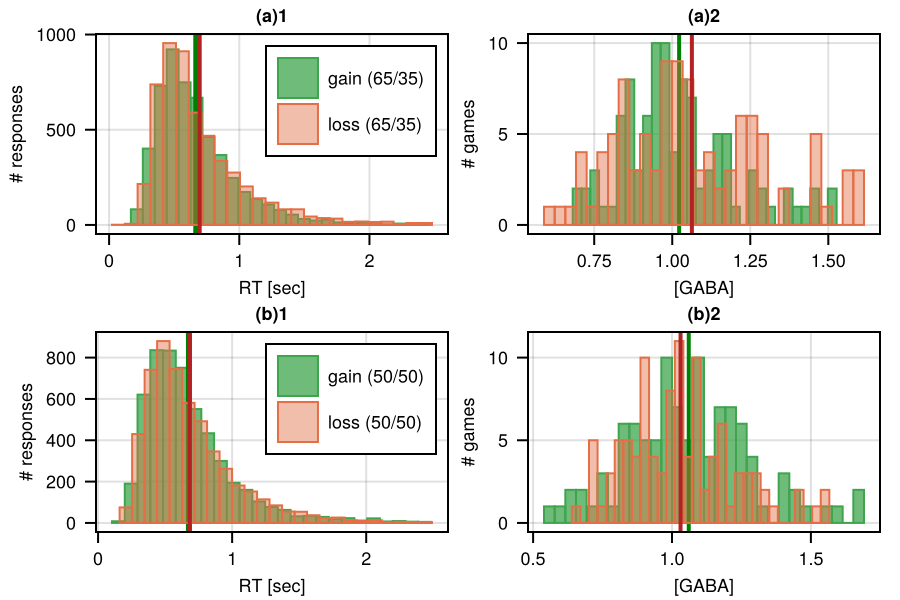

In [5]:
flag_start = 1; println("start trial: $(flag_start)")
fig = Figure(size=(450, 300), fontsize=9, figure_padding=(3, 10, 3, 3)); ax = [];  #400, 300
    push!(ax, Axis(fig[1, 1], xlabel="RT [sec]", ylabel="# responses", title="(a)1"));
    push!(ax, Axis(fig[2, 1], xlabel="RT [sec]", ylabel="# responses", title="(b)1"));
    push!(ax, Axis(fig[1, 2], xlabel="[GABA]",    ylabel="# games", title="(a)2"));
    push!(ax, Axis(fig[2, 2], xlabel="[GABA]",    ylabel="# games", title="(b)2"));

cols_dark = [:green, :firebrick]; label_rate=["65/35", "50/50"];
for (ind_rate, cond_rate) in enumerate([cond_rate1, cond_rate2]) 
    for (ind_gl, cond_gl) in enumerate(["gain", "loss"])       
        df_game = df_rawdata[(df_rawdata.cond_rate .== cond_rate) .& (df_rawdata.cond_gl .== cond_gl), :];
        rt_id   = Array{Float64, 1}();
        GABA_id = Array{Float64, 1}();

        for row in eachrow(df_game)
            append!(rt_id,   filter(!isnan, row.rts_raw[flag_start:end]));
            append!(GABA_id, row.GABA_task);
        end
        ndigits = 2;
        hist!(ax[ind_rate], rt_id, color=(c[ind_gl+1], 1.05-0.3*ind_gl), bins=25, strokecolor=c[ind_gl+1], strokewidth=1, label="$(cond_gl) ($(label_rate[ind_rate]))");
        vlines!(ax[ind_rate], [nanmean(rt_id)], linewidth=4-ind_gl, color=cols_dark[ind_gl])#, linestyle= ind_gl!=1 ? :dash : :solid);
        println("$(cond_gl) $(cond_rate):  RT mean ± STD = $((round(nanmean(rt_id), digits=ndigits))) ± $((round(nanstd(rt_id), digits=ndigits))) ± $((round(nanse(rt_id), digits=ndigits)))")
        hist!(ax[ind_rate+2], filter(!isnan, GABA_id), color=(c[ind_gl+1], 1.05-0.3*ind_gl), bins=30, strokecolor=c[ind_gl+1], strokewidth=1, label="$(cond_gl), $(Int8(cond_rate*100))%");
        vlines!(ax[ind_rate+2], [nanmean(GABA_id)], linewidth=2, color=cols_dark[ind_gl]);
        println("$(cond_gl) $(cond_rate): GABA mean ± STD = $((round(nanmean(GABA_id), digits=ndigits))) ± $((round(nanstd(GABA_id), digits=ndigits))) ± $((round(nanse(GABA_id), digits=ndigits)))")
    end
end
axislegend(ax[1], position=:rt) #, height=70, rowgap=0)  #, colgap = 30, rawgap = -1,  tellheight=true, nbanks=1, margin=(0,3,3,0), padding=(3,3,0,0),
axislegend(ax[2], position=:rt);
colgap!(fig.layout, 6); rowgap!(fig.layout, 4)
fig

## RT RTcRTw GABA vs error: SI fig. S20

gain35 #80 Error rate: 0.235 ± 0.145; 0.235 ± 0.016
gain35 #80 RT: 0.654 ± 0.193; 0.654 ± 0.022
gain35 #70 RTc/RTw: 0.935 ± 0.22; 0.935 ± 0.026
gain35 #74 GABA: 1.021 ± 0.181; 1.021 ± 0.021
loss35 #78 Error rate: 0.237 ± 0.137; 0.237 ± 0.016
loss35 #78 RT: 0.688 ± 0.232; 0.688 ± 0.026
loss35 #72 RTc/RTw: 0.978 ± 0.211; 0.978 ± 0.025
loss35 #77 GABA: 1.076 ± 0.223; 1.076 ± 0.025


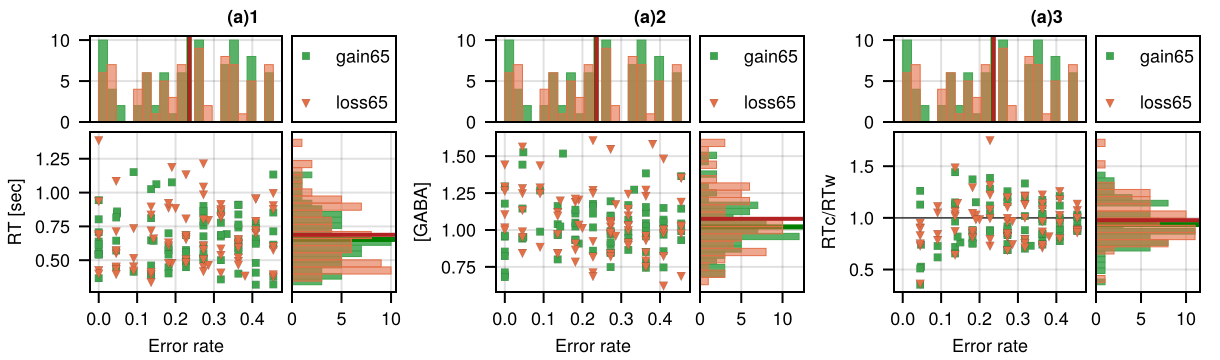

In [7]:
fig = Figure(size=(610, 180), fontsize=9, figure_padding=(3, 10, 3, 3)); ax = [];  #400, 300
    ga = fig[1, 1] = GridLayout();
        axatop   = Axis(ga[1, 1], )#limits=((0, nothing), (nothing, nothing)))
        axamain  = Axis(ga[2, 1], xlabel = "Error rate", ylabel = "RT [sec]")
        axaright = Axis(ga[2, 2], )#limits=((nothing, nothing), (0, nothing)))
        linkyaxes!(axamain, axaright);  linkxaxes!(axamain, axatop)
        xlims!(axaright, low = 0);      ylims!(axatop, low = 0); 
        hideydecorations!(axaright, grid = false); hidexdecorations!(axatop, grid = false);
        Label(ga[1, 1:2, Top()], "(a)1", valign = :bottom, font = :bold, padding = (0, 0, 5, 0))
    gc = fig[1, 2] = GridLayout();
        axctop   = Axis(gc[1, 1], )#limits=((0, nothing), (nothing, nothing)))
        axcmain  = Axis(gc[2, 1], xlabel = "Error rate", ylabel = "[GABA]")
        axcright = Axis(gc[2, 2], )#limits=((nothing, nothing), (0, nothing)))
        linkyaxes!(axcmain, axcright);  linkxaxes!(axcmain, axctop)
        xlims!(axcright, low = 0);      ylims!(axctop, low = 0); 
        hideydecorations!(axcright, grid = false); hidexdecorations!(axctop, grid = false);
        Label(gc[1, 1:2, Top()], "(a)2", valign = :bottom, font = :bold, padding = (0, 0, 5, 0))
    gb = fig[1, 3] = GridLayout();
        axbtop   = Axis(gb[1, 1])
        axbmain  = Axis(gb[2, 1], xlabel="Error rate", ylabel="RTc/RTw")
        axbright = Axis(gb[2, 2])
        linkyaxes!(axbmain, axbright);   linkxaxes!(axbmain, axbtop);
        xlims!(axbright, low = 0);       ylims!(axbtop, low = 0); 
        hideydecorations!(axbright, grid = false); hidexdecorations!(axbtop, grid = false);
        Label(gb[1, 1:2, Top()], "(a)3", valign = :bottom, font = :bold, padding = (0, 0, 5, 0))
        hlines!(axbmain, [1], color=:gray25, linewidth=0.8);
markers=[:rect, :dtriangle, :diamond, :circle];
cols   =[c[2], c[3], c[1], c[4]]; cols_dark = [:green, :firebrick, :dodgerblue2, :blueviolet]; label_rate=["65/35", "50/50"];
col = 1;
#for (ind_rate, cond_rate) in enumerate([cond_rate1, cond_rate2]) 
ind_rate = 1; cond_rate = [cond_rate1, cond_rate2][ind_rate];
    for (ind_gl, cond_gl) in enumerate(["gain", "loss"])   
        df_game = df_rawdata[(df_rawdata.cond_rate .== cond_rate) .& (df_rawdata.cond_gl .== cond_gl) .& (df_rawdata.status .== 1), :];
        
        error_id  = fill(NaN, nparticipants);
        rt_id     = fill(NaN, nparticipants);
        rtcrtw_id = fill(NaN, nparticipants);
        GABA_id   = fill(NaN, nparticipants);

        for row in eachrow(df_game)
            error_id[ row.id] = row.error;
            rt_id[    row.id] = row.rt_mean;
            rtcrtw_id[row.id] = row.ratio_cw;
            GABA_id[  row.id] = row.GABA_task;
        end
        if true
            #vlines!(axamain, [mean(error_id)], linewidth=2, color=cond=="gain" ? :green : :firebrick)
            #hlines!(axamain, [mean(rt_id)],    linewidth=2, color=cond=="gain" ? :green : :firebrick)
            scatter!(axamain, error_id, rt_id,     markersize=6, color=cols[col], marker=markers[col], strokewidth=0.05, label="$(cond_gl)$(Int8((1-cond_rate)*100))")
            scatter!(axbmain, error_id, rtcrtw_id, markersize=6, color=cols[col], marker=markers[col], strokewidth=0.05, label="$(cond_gl)$(Int8((1-cond_rate)*100))")
            scatter!(axcmain, error_id, GABA_id,   markersize=6, color=cols[col], marker=markers[col], strokewidth=0.05, label="$(cond_gl)$(Int8((1-cond_rate)*100))")
            hist!(axatop,   filter(!isnan, error_id),  bins=20, color=(cols[col], 1.1-0.25*col), strokewidth=0.5, strokecolor=cols[col], )
            hist!(axaright, filter(!isnan, rt_id),     bins=20, color=(cols[col], 1.1-0.25*col), strokewidth=0.5, strokecolor=cols[col], direction = :x)  #, offset=0, scale_to = 1)
            hist!(axbtop,   filter(!isnan, error_id),  bins=20, color=(cols[col], 1.1-0.25*col), strokewidth=0.5, strokecolor=cols[col], )
            hist!(axbright, filter(!isnan, rtcrtw_id), bins=20, color=(cols[col], 1.1-0.25*col), strokewidth=0.5, strokecolor=cols[col], direction = :x)  #, offset=0, scale_to = 1)
            hist!(axctop,   filter(!isnan, error_id),  bins=20, color=(cols[col], 1.1-0.25*col), strokewidth=0.5, strokecolor=cols[col], )
            hist!(axcright, filter(!isnan, GABA_id),   bins=20, color=(cols[col], 1.1-0.25*col), strokewidth=0.5, strokecolor=cols[col], direction = :x)  #, offset=0, scale_to = 1)
            vlines!(axatop,   [nanmean(error_id)],  linewidth=3-0.5*ind_gl, color=cols_dark[col])
            hlines!(axaright, [nanmean(rt_id)],     linewidth=3-0.5*ind_gl, color=cols_dark[col])
            vlines!(axbtop,   [nanmean(error_id)],  linewidth=3-0.5*ind_gl, color=cols_dark[col])
            hlines!(axbright, [nanmean(rtcrtw_id)], linewidth=3-0.5*ind_gl, color=cols_dark[col])
            vlines!(axctop,   [nanmean(error_id)],  linewidth=3-0.5*ind_gl, color=cols_dark[col])
            hlines!(axcright, [nanmean(GABA_id)],   linewidth=3-0.5*ind_gl, color=cols_dark[col])
            println("$(cond_gl)$(Int8(cond_rate*100)) #$(nanlength(error_id)) Error rate: ", round(nanmean(error_id), digits=3),  " ± ", round(nanstd(error_id), digits=3) , "; ", round(nanmean(error_id), digits=3), " ± ", round(nanse(error_id), digits=3) )
            println("$(cond_gl)$(Int8(cond_rate*100)) #$(nanlength(rt_id)) RT: ",            round(nanmean(rt_id), digits=3),     " ± ", round(nanstd(rt_id), digits=3)    , "; ", round(nanmean(rt_id), digits=3),    " ± ", round(nanse(rt_id), digits=3)    )
            println("$(cond_gl)$(Int8(cond_rate*100)) #$(nanlength(rtcrtw_id)) RTc/RTw: ",   round(nanmean(rtcrtw_id), digits=3), " ± ", round(nanstd(rtcrtw_id), digits=3), "; ", round(nanmean(rtcrtw_id), digits=3)," ± ", round(nanse(rtcrtw_id), digits=3))
            println("$(cond_gl)$(Int8(cond_rate*100)) #$(nanlength(GABA_id)) GABA: ",        round(nanmean(GABA_id), digits=3),   " ± ", round(nanstd(GABA_id), digits=3)  , "; ", round(nanmean(GABA_id), digits=3),  " ± ", round(nanse(GABA_id), digits=3)  )
            col += 1;
        end
end
colgap!(fig.layout, 8);
    #colsize!(fig.layout, 1, Relative(0.5)); colsize!(fig.layout, 2, Relative(0.5))
    colgap!(ga, 5); rowgap!(ga, 5); colgap!(gb, 5); rowgap!(gb, 5); colgap!(gc, 5); rowgap!(gc, 5)
    lega = Legend(ga[1, 2], axamain, tellheight=true, padding=(-3,3,0,0));  #, tellheight=true , width=55 height=70, rowgap=0)  #, colgap = 30, rawgap = -1,  tellheight=true, nbanks=1, margin=(0,3,3,0), padding=(3,3,0,0),
    legb = Legend(gb[1, 2], axbmain, tellheight=true, padding=(-3,3,0,0));  #, tellheight=true , width=55 
    legc = Legend(gc[1, 2], axcmain, tellheight=true, padding=(-3,3,0,0));  #, tellheight=true , width=55 
#rowsize!(fig.layout, 1, Relative(0.3))
fig

gain50 #88 Error rate: 0.496 ± 0.139 & 0.496 ± 0.015
gain50 #88 RT: 0.655 ± 0.234 & 0.655 ± 0.025
gain50 #85 GABA: 1.047 ± 0.218 & 1.047 ± 0.024
loss50 #89 Error rate: 0.517 ± 0.123 & 0.517 ± 0.013
loss50 #89 RT: 0.677 ± 0.205 & 0.677 ± 0.022
loss50 #87 GABA: 1.027 ± 0.2 & 1.027 ± 0.021


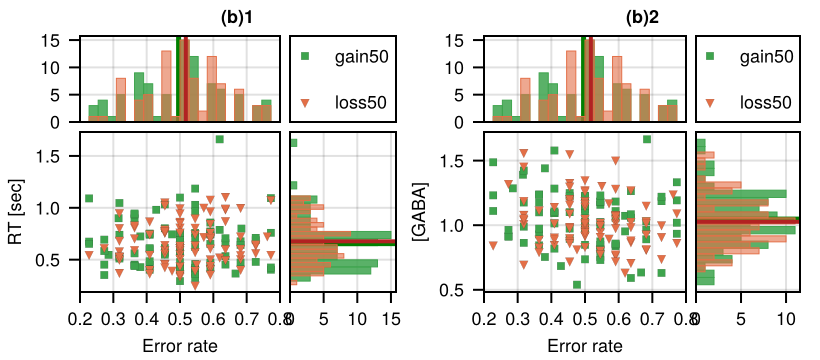

In [ ]:
fig = Figure(size=(410, 180), fontsize=9, figure_padding=(3, 10, 3, 3)); ax = [];  #400, 300
    ga = fig[1, 1] = GridLayout();
        axatop   = Axis(ga[1, 1], )#limits=((0, nothing), (nothing, nothing)))
        axamain  = Axis(ga[2, 1], xlabel = "Error rate", ylabel = "RT [sec]")
        axaright = Axis(ga[2, 2], )#limits=((nothing, nothing), (0, nothing)))
        linkyaxes!(axamain, axaright);  linkxaxes!(axamain, axatop)
        xlims!(axaright, low = 0);      ylims!(axatop, low = 0); 
        hideydecorations!(axaright, grid = false); hidexdecorations!(axatop, grid = false);
        Label(ga[1, 1:2, Top()], "(b)1", valign = :bottom, font = :bold, padding = (0, 0, 5, 0))
    gc = fig[1, 2] = GridLayout();
        axctop   = Axis(gc[1, 1], )#limits=((0, nothing), (nothing, nothing)))
        axcmain  = Axis(gc[2, 1], xlabel = "Error rate", ylabel = "[GABA]")
        axcright = Axis(gc[2, 2], )#limits=((nothing, nothing), (0, nothing)))
        linkyaxes!(axcmain, axcright);  linkxaxes!(axcmain, axctop)
        xlims!(axcright, low = 0);      ylims!(axctop, low = 0); 
        hideydecorations!(axcright, grid = false); hidexdecorations!(axctop, grid = false);
        Label(gc[1, 1:2, Top()], "(b)2", valign = :bottom, font = :bold, padding = (0, 0, 5, 0))
markers=[:rect, :dtriangle, :diamond, :circle];
cols   =[c[2], c[3], c[1], c[4]]; cols_dark = [:green, :firebrick, :dodgerblue2, :blueviolet]; label_rate=["65/35", "50/50"];
col = 1;
#for (ind_rate, cond_rate) in enumerate([cond_rate1, cond_rate2]) 
ind_rate = 2; cond_rate = [cond_rate1, cond_rate2][ind_rate];
    for (ind_gl, cond_gl) in enumerate(["gain", "loss"])   
        df_game = df_rawdata[(df_rawdata.cond_rate .== cond_rate) .& (df_rawdata.cond_gl .== cond_gl) .& (df_rawdata.status .== 1), :];
        
        error_id  = fill(NaN, nparticipants);
        rt_id     = fill(NaN, nparticipants);
        GABA_id   = fill(NaN, nparticipants);

        for row in eachrow(df_game)
            error_id[ row.id] = row.error;
            rt_id[    row.id] = row.rt_mean;
            GABA_id[  row.id] = row.GABA_task;
        end
        if true
            #vlines!(axamain, [mean(error_id)], linewidth=2, color=cond=="gain" ? :green : :firebrick)
            #hlines!(axamain, [mean(rt_id)],    linewidth=2, color=cond=="gain" ? :green : :firebrick)
            scatter!(axamain, error_id, rt_id,     markersize=6, color=cols[col], marker=markers[col], strokewidth=0.05, label="$(cond_gl)$(Int8((1-cond_rate)*100))")
            scatter!(axcmain, error_id, GABA_id,   markersize=6, color=cols[col], marker=markers[col], strokewidth=0.05, label="$(cond_gl)$(Int8((1-cond_rate)*100))")
            hist!(axatop,   filter(!isnan, error_id),  bins=20, color=(cols[col], 1.1-0.25*col), strokewidth=0.5, strokecolor=cols[col], )
            hist!(axaright, filter(!isnan, rt_id),     bins=20, color=(cols[col], 1.1-0.25*col), strokewidth=0.5, strokecolor=cols[col], direction = :x)  #, offset=0, scale_to = 1)
            hist!(axctop,   filter(!isnan, error_id),  bins=20, color=(cols[col], 1.1-0.25*col), strokewidth=0.5, strokecolor=cols[col], )
            hist!(axcright, filter(!isnan, GABA_id),   bins=20, color=(cols[col], 1.1-0.25*col), strokewidth=0.5, strokecolor=cols[col], direction = :x)  #, offset=0, scale_to = 1)
            vlines!(axatop,   [nanmean(error_id)],  linewidth=3-0.5*ind_gl, color=cols_dark[col])
            hlines!(axaright, [nanmean(rt_id)],     linewidth=3-0.5*ind_gl, color=cols_dark[col])
            vlines!(axctop,   [nanmean(error_id)],  linewidth=3-0.5*ind_gl, color=cols_dark[col])
            hlines!(axcright, [nanmean(GABA_id)],   linewidth=3-0.5*ind_gl, color=cols_dark[col])
            println("$(cond_gl)$(Int8(cond_rate*100)) #$(nanlength(error_id)) Error rate: ", round(nanmean(error_id), digits=3), " ± ", round(nanstd(error_id), digits=3), " & ", round(nanmean(error_id), digits=3)," ± ", round(nanse(error_id), digits=3))
            println("$(cond_gl)$(Int8(cond_rate*100)) #$(nanlength(rt_id)) RT: ",            round(nanmean(rt_id), digits=3),    " ± ", round(nanstd(rt_id), digits=3)   , " & ", round(nanmean(rt_id), digits=3),   " ± ", round(nanse(rt_id), digits=3)   )
            println("$(cond_gl)$(Int8(cond_rate*100)) #$(nanlength(GABA_id)) GABA: ",        round(nanmean(GABA_id), digits=3),  " ± ", round(nanstd(GABA_id), digits=3) , " & ", round(nanmean(GABA_id), digits=3), " ± ", round(nanse(GABA_id), digits=3) )
            col += 1;
        end
end
colgap!(fig.layout, 8);
    #colsize!(fig.layout, 1, Relative(0.5)); colsize!(fig.layout, 2, Relative(0.5))
    colgap!(ga, 5); rowgap!(ga, 5); colgap!(gc, 5); rowgap!(gc, 5)
    lega = Legend(ga[1, 2], axamain, tellheight=true, padding=(-3,3,0,0));  #, tellheight=true , width=55 height=70, rowgap=0)  #, colgap = 30, rawgap = -1,  tellheight=true, nbanks=1, margin=(0,3,3,0), padding=(3,3,0,0),
    legc = Legend(gc[1, 2], axcmain, tellheight=true, padding=(-3,3,0,0));  #, tellheight=true , width=55 
#rowsize!(fig.layout, 1, Relative(0.3))
fig

## Tests for comparison of gain vs. loss trials : SI tab. S5, S6

In [8]:
function return_ER_RT_cw_GABA(df_rawdata, cond_rate, cond_gl)

    df_game = df_rawdata[(df_rawdata.cond_rate .== cond_rate) .& (df_rawdata.cond_gl .== cond_gl) .& (df_rawdata.status .== 1), :];

    error_id  = fill(NaN, nparticipants);
    rt_id     = fill(NaN, nparticipants);
    rtcrtw_id = fill(NaN, nparticipants);
    GABA_id   = fill(NaN, nparticipants);

    for row in eachrow(df_game)
        error_id[ row.id] = row.error;
        rt_id[    row.id] = row.rt_mean;
        rtcrtw_id[row.id] = row.ratio_cw;
        GABA_id[  row.id] = row.GABA_task;
    end

    filter!(!isnan, error_id)
    filter!(!isnan, rt_id)
    filter!(!isnan, rtcrtw_id)
    filter!(!isnan, GABA_id)

    return error_id, rt_id, rtcrtw_id, GABA_id
end

return_ER_RT_cw_GABA (generic function with 1 method)

In [9]:
function print_TTest_Wilcoxon(vec1, vec2, label, cond_rate, ttestflag)

    #error_id_gain, rt_id_gain, rtcrtw_id_gain, GABA_id_gain = return_ER_RT_cw_GABA(df_rawdata, cond_rate, "gain");
    #error_id_loss, rt_id_loss, rtcrtw_id_loss, GABA_id_loss = return_ER_RT_cw_GABA(df_rawdata, cond_rate, "loss");

    println("$(label) $(Int8(cond_rate*100)): sizes $(length(vec1)) and $(length(vec2))")
    println("gain = $(round(nanmean(vec1), digits=3)) ± $(round(nanstd(vec1),  digits=3))")
    println("loss = $(round(nanmean(vec2), digits=3)) ± $(round(nanstd(vec2),  digits=3))")
    if ttestflag == "equal_var"
        try ttest_res = EqualVarianceTTest(vec1, vec2)
        println("T-test: df = $(ttest_res.df), t = $(round(ttest_res.t, digits=4)), p = $(round(pvalue(ttest_res), digits=4))")
        catch x end
    elseif ttestflag == "unequal_var"
        try ttest_res = UnequalVarianceTTest(vec1, vec2)
        println("T-test: df = $(round(ttest_res.df, digits=2)), t = $(round(ttest_res.t, digits=4)), p = $(round(pvalue(ttest_res), digits=4))")
        catch x end
    end
    try
    Wilcoxon_res = SignedRankTest(vec1, vec2)
    println("Wilcoxon: df = $(Wilcoxon_res.n), W = $(Wilcoxon_res.W), p = $(round(pvalue(Wilcoxon_res), digits=4))")
    catch x end
end

print_TTest_Wilcoxon (generic function with 1 method)

In [10]:
ttestflag = "equal_var";  # "equal_var", "unequal_var"

ind_rate = 1;  cond_rate = [cond_rate1, cond_rate2][ind_rate]; println(cond_rate)

# SignedRankTest, OneSampleTTest, TwoSampleTTest, UnequalVarianceTTest, EqualVarianceTTest
error_id_gain, rt_id_gain, rtcrtw_id_gain, GABA_id_gain = return_ER_RT_cw_GABA(df_rawdata, cond_rate, "gain");
error_id_loss, rt_id_loss, rtcrtw_id_loss, GABA_id_loss = return_ER_RT_cw_GABA(df_rawdata, cond_rate, "loss");

labels = ["Error rate", "RT", "GABA", "RTc/RTw"];
vecs = [[error_id_gain, error_id_loss],
        [rt_id_gain,    rt_id_loss],
        [GABA_id_gain, GABA_id_loss],
        [rtcrtw_id_gain, rtcrtw_id_loss],
        ];

for (ind, label) in enumerate(labels)
    vec1 = vecs[ind][1];
    vec2 = vecs[ind][2];
    print_TTest_Wilcoxon(vec1, vec2, label, cond_rate, ttestflag)
end

0.35
Error rate 35: sizes 80 and 78
gain = 0.235 ± 0.145
loss = 0.237 ± 0.137
T-test: df = 156, t = -0.0561, p = 0.9553
RT 35: sizes 80 and 78
gain = 0.654 ± 0.193
loss = 0.688 ± 0.232
T-test: df = 156, t = -0.9983, p = 0.3197
GABA 35: sizes 74 and 77
gain = 1.021 ± 0.181
loss = 1.076 ± 0.223
T-test: df = 149, t = -1.6462, p = 0.1018
RTc/RTw 35: sizes 70 and 72
gain = 0.935 ± 0.22
loss = 0.978 ± 0.211
T-test: df = 140, t = -1.1774, p = 0.241


In [11]:
println("RTc/RTw(gain) = $(round(nanmean(rtcrtw_id_gain), digits=3)) ± $(round(nanstd(rtcrtw_id_gain), digits=3)) (STD)")
println("RTc/RTw(gain) = $(round(nanmean(rtcrtw_id_gain), digits=3)) ± $(round(nanse(rtcrtw_id_gain), digits=3)) (SE)")
println("RTc/RTw(gain) != 1:")
ttest_res = OneSampleTTest(rtcrtw_id_gain .- 1)
println("T-test: df = $(ttest_res.df), t = $(round(ttest_res.t, digits=4)), p = $(round(pvalue(ttest_res), digits=4))")
Wilcoxon_res = SignedRankTest(rtcrtw_id_gain .- 1)
println("Wilcoxon: df = $(Wilcoxon_res.n), W = $(Wilcoxon_res.W), p = $(round(pvalue(Wilcoxon_res), digits=4))")

println("RTc/RTw(loss) = $(round(nanmean(rtcrtw_id_loss), digits=3)) ± $(round(nanstd(rtcrtw_id_loss), digits=3)) (STD)")
println("RTc/RTw(loss) = $(round(nanmean(rtcrtw_id_loss), digits=3)) ± $(round(nanse(rtcrtw_id_loss), digits=3)) (SE)")
println("RTc/RTw(loss) != 1:")
ttest_res = OneSampleTTest(rtcrtw_id_loss .- 1)
println("T-test: df = $(ttest_res.df), t = $(round(ttest_res.t, digits=4)), p = $(round(pvalue(ttest_res), digits=4))")
Wilcoxon_res = SignedRankTest(rtcrtw_id_loss .- 1)
println("Wilcoxon: df = $(Wilcoxon_res.n), W = $(Wilcoxon_res.W), p = $(round(pvalue(Wilcoxon_res), digits=4))")

RTc/RTw(gain) = 0.935 ± 0.22 (STD)
RTc/RTw(gain) = 0.935 ± 0.026 (SE)
RTc/RTw(gain) != 1:
T-test: df = 69, t = -2.4682, p = 0.0161
Wilcoxon: df = 70, W = 848.0, p = 0.0211
RTc/RTw(loss) = 0.978 ± 0.211 (STD)
RTc/RTw(loss) = 0.978 ± 0.025 (SE)
RTc/RTw(loss) != 1:
T-test: df = 71, t = -0.9025, p = 0.3699
Wilcoxon: df = 72, W = 1084.0, p = 0.1978


In [12]:
ttestflag = "equal_var";  # "equal_var", "unequal_var"

ind_rate = 2;  cond_rate = [cond_rate1, cond_rate2][ind_rate]; println(cond_rate)

# SignedRankTest, OneSampleTTest, TwoSampleTTest, UnequalVarianceTTest, EqualVarianceTTest
error_id_gain, rt_id_gain, rtcrtw_id_gain, GABA_id_gain = return_ER_RT_cw_GABA(df_rawdata, cond_rate, "gain");
error_id_loss, rt_id_loss, rtcrtw_id_loss, GABA_id_loss = return_ER_RT_cw_GABA(df_rawdata, cond_rate, "loss");

labels = ["Error rate", "RT", "GABA", "RTc/RTw"];
vecs = [[error_id_gain, error_id_loss],
        [rt_id_gain,    rt_id_loss],
        [GABA_id_gain, GABA_id_loss],
        [rtcrtw_id_gain, rtcrtw_id_loss],
        ];
        
for (ind, label) in enumerate(labels)
    vec1 = vecs[ind][1];
    vec2 = vecs[ind][2];
    print_TTest_Wilcoxon(vec1, vec2, label, cond_rate, ttestflag)
end

0.5
Error rate 50: sizes 88 and 89
gain = 0.496 ± 0.139
loss = 0.517 ± 0.123
T-test: df = 175, t = -1.0984, p = 0.2736
RT 50: sizes 88 and 89
gain = 0.655 ± 0.234
loss = 0.677 ± 0.205
T-test: df = 175, t = -0.6671, p = 0.5056
GABA 50: sizes 85 and 87
gain = 1.047 ± 0.218
loss = 1.027 ± 0.2
T-test: df = 170, t = 0.6497, p = 0.5168
RTc/RTw 50: sizes 88 and 89
gain = 1.016 ± 0.177
loss = 1.049 ± 0.215
T-test: df = 175, t = -1.1099, p = 0.2686


## Learning period: SI fig. S19

In [14]:
error_threshold = [ 0.0, 0.15 ]; ## here we define the error threshold for grouping: blue/green/orange
println(sort(unique(df_group1.error)))

df_group1.group_error .= 3;
df_group1[(df_group1.rt_norm .≤ 1) .& (error_threshold[1] .≤ df_group1.error .< error_threshold[2]), :group_error] .= 2;
df_group1[(df_group1.rt_norm .> 1) .& (error_threshold[1] .≤ df_group1.error .< error_threshold[2]), :group_error] .= 1;
groups = sort(unique(df_group1[df_group1.group_error .!= 0, :group_error]));
println(groups)

[0.0, 0.045454545454545414, 0.04761904761904767, 0.09090909090909094, 0.13636363636363635, 0.1428571428571429, 0.15000000000000002, 0.18181818181818177, 0.19047619047619047, 0.19999999999999996, 0.2272727272727273, 0.2727272727272727, 0.2857142857142857, 0.31818181818181823, 0.33333333333333337, 0.36363636363636365, 0.38095238095238093, 0.40909090909090906, 0.4545454545454546]
[1, 2, 3]


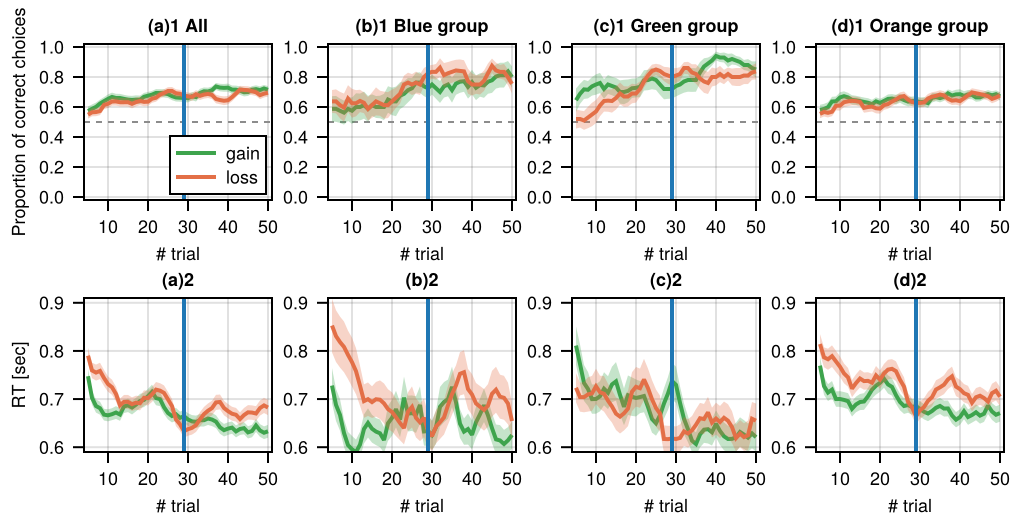

In [15]:
delta = 5;  #window for averaging
start_trial_learning = delta;
last_trial = 50;  #size(choices_gain, 1);

groups = 1:3;
groupnames    = ["(a)1 All", "(b)1 Blue group", "(c)1 Green group", "(d)1 Orange group"];
groupnames_RT = ["(a)2", "(b)2", "(c)2", "(d)2"];
fig = Figure(size=(510, 260), fontsize=9, figure_padding=(5, 8, 3, 8)); ax = []; #400, 300
    [push!(ax, Axis(fig[1, group], xlabel="# trial", ylabel=group==1 ? "Proportion of correct choices" : "", title="$(groupnames[group])", 
                   limits=((delta-1, last_trial+1), (-0.02, 1.02)), xticks=10:10:100, yticks=0:0.2:1)) for group in 1:4];
    [hlines!(axi, [0.5], color=:grey55, linestyle=:dash, linewidth=1)  for axi in ax];
    [push!(ax, Axis(fig[2, group], xlabel="# trial", ylabel=group==1 ? "RT [sec]" : "", title="$(groupnames_RT[group])", 
                   limits=((delta-1, last_trial+1), (0.59, 0.91)), xticks=10:10:100)) for group in 1:4];
for (indcond, condgl) in enumerate(["gain", "loss"])
    errors_vec = fill(NaN, last_trial - start_trial_learning+1);
    std_vec    = fill(NaN, last_trial - start_trial_learning+1);
    RT_vec     = fill(NaN, last_trial - start_trial_learning+1);
    RTSE_vec   = fill(NaN, last_trial - start_trial_learning+1);
    df = df_rawdata[(df_rawdata.cond_gl .== condgl) .&& (df_rawdata.cond_rate .== 0.35), :];
    for trial in start_trial_learning:last_trial
        choices_vec = [nanmean(df[ii, :choices_raw][trial-delta+1:trial]) for ii in 1:size(df, 1)];
        errors_vec[trial-delta+1] = 1 - nanmean(choices_vec);
        std_vec[trial-delta+1] = nanse(choices_vec);
        RT_vec[trial-delta+1]  = nanmean(vcat([df[ii, :rts_raw][trial-delta+1:trial] for ii in 1:size(df, 1)]...));
        RTSE_vec[trial-delta+1]= nanse(vcat([df[ii, :rts_raw][trial-delta+1:trial] for ii in 1:size(df, 1)]...));
    end
    band!( ax[1], start_trial_learning:last_trial, 1 .- errors_vec.+std_vec, 1 .- errors_vec.-std_vec, color=(c[indcond+1], 0.3))
    lines!(ax[1], start_trial_learning:last_trial, 1 .- errors_vec, color=c[indcond+1], linewidth=2, label=condgl);
    band!( ax[5], start_trial_learning:last_trial, RT_vec.+RTSE_vec, RT_vec.-RTSE_vec, color=(c[indcond+1], 0.3))
    lines!(ax[5], start_trial_learning:last_trial, RT_vec, color=c[indcond+1], linewidth=2, label=condgl);
end
axislegend(ax[1], position=:rb, tellheight=true, nbanks=1, margin=(0,3,3,0), padding=(3,3,0,0), height=32,  rowgap=-8)  #, colgap = 30, rawgap = -1
#axislegend(ax[1], position=:rb, margin=(0,3,3,0), padding=(3,2,0,0), fontsize=2);
for group in 1:3
    for (indcond, condgl) in enumerate(["gain", "loss"])
        errors_vec = fill(NaN, last_trial - start_trial_learning+1);
        std_vec    = fill(NaN, last_trial - start_trial_learning+1);
        RT_vec     = fill(NaN, last_trial - start_trial_learning+1);
        RTSE_vec   = fill(NaN, last_trial - start_trial_learning+1);
        ids_in_group = Int64.(df_group1[(df_group1.group_error .== group) .&& (df_group1.status .== 1), :id]);
        df = df_rawdata[(df_rawdata.cond_gl .== condgl) .&& (df_rawdata.cond_rate .== 0.35) .&& (df_rawdata.id .∈ Ref(ids_in_group)), :];
        for trial in start_trial_learning:last_trial
            choices_vec = [nanmean(df[ii, :choices_raw][trial-delta+1:trial]) for ii in 1:size(df, 1)];
            errors_vec[trial-delta+1] = 1 - nanmean(choices_vec);
            std_vec[trial-delta+1] = nanse(choices_vec);
            RT_vec[trial-delta+1]  = nanmean(vcat([df[ii, :rts_raw][trial-delta+1:trial] for ii in 1:size(df, 1)]...));
            RTSE_vec[trial-delta+1]= nanse(vcat([df[ii, :rts_raw][trial-delta+1:trial] for ii in 1:size(df, 1)]...));
        end
        band!( ax[group+1], start_trial_learning:last_trial, 1 .- errors_vec.+std_vec, 1 .- errors_vec.-std_vec, color=(c[indcond+1], 0.3))
        lines!(ax[group+1], start_trial_learning:last_trial, 1 .- errors_vec, color=c[indcond+1], linewidth=2, label=condgl);
        band!( ax[group+5], start_trial_learning:last_trial, RT_vec.+RTSE_vec, RT_vec.-RTSE_vec, color=(c[indcond+1], 0.3))
        lines!(ax[group+5], start_trial_learning:last_trial, RT_vec, color=c[indcond+1], linewidth=2, label=condgl);
    end
end
[vlines!(axi, [start_trial], color=c[1], linewidth=2)  for axi in ax];
rowgap!(fig.layout, 4); colgap!(fig.layout, 7)
fig

## tests GABA for the 3 groups: SI tab. S8 (gain and loss combined)

In [16]:
error_threshold = [ 0.0, 0.15 ]; ## CHANGE TO 0.1 or 0.2
println(sort(unique(df_group1.error)))

if true
    df_group1.group_error .= 3;
    df_group1[(df_group1.rt_norm .≤ 1) .& (error_threshold[1] .≤ df_group1.error .< error_threshold[2]), :group_error] .= 2;
    df_group1[(df_group1.rt_norm .> 1) .& (error_threshold[1] .≤ df_group1.error .< error_threshold[2]), :group_error] .= 1;
    groups = sort(unique(df_group1[df_group1.group_error .!= 0, :group_error]));
    println(groups)

    df_group1.normGABA_3550 = fill(NaN, size(df_group1)[1]);
    df_group1.normGABA_cond50 = fill("", size(df_group1)[1]);
    df_group1.normGABA_50 = fill(NaN, size(df_group1)[1]);
    for row in eachrow(df_group1)
        id = row.id;
        cond = row.cond_gl;
        GABA35 = row.GABA_task[1];
        row50 = df_rawdata[(df_rawdata.id .== id) .& (df_rawdata.cond_gl .== cond) .& (df_rawdata.cond_rate .== 0.5), :];
        GABA50 = row50.GABA_task[1];
        row.normGABA_cond50 = cond;
        row.normGABA_3550 = GABA35 / GABA50;
        row.normGABA_50 = GABA50;
    end

    GABAgreen_50 = filter(!isnan, df_group1[df_group1.group_error .== 2, :].normGABA_50);
    GABAblue_50 = filter(!isnan, df_group1[df_group1.group_error .== 1, :].normGABA_50);
    GABAgreen_35 = filter(!isnan, df_group1[df_group1.group_error .== 2, :].GABA_task);
    GABAblue_35 = filter(!isnan, df_group1[df_group1.group_error .== 1, :].GABA_task);
    GABAorange_50 = filter(!isnan, df_group1[df_group1.group_error .== 3, :].normGABA_50);
    GABAorange_35 = filter(!isnan, df_group1[df_group1.group_error .== 3, :].GABA_task);
end
println("GABA (mean ± std & mean ± SE & # observations):
green35 = $( round(nanmean(GABAgreen_35), digits=3)) ± $( round(nanstd(GABAgreen_35), digits=3)) & $( round(nanmean(GABAgreen_35), digits=3)) ± $( round(nanse(GABAgreen_35), digits=3)) & $( nanlength(GABAgreen_35))
green50 = $( round(nanmean(GABAgreen_50), digits=3)) ± $( round(nanstd(GABAgreen_50), digits=3)) & $( round(nanmean(GABAgreen_50), digits=3)) ± $( round(nanse(GABAgreen_50), digits=3)) & $( nanlength(GABAgreen_50))
blue35  = $( round(nanmean(GABAblue_35), digits=3)) ± $(  round(nanstd(GABAblue_35), digits=3)) & $(  round(nanmean(GABAblue_35), digits=3)) ± $(  round(nanse(GABAblue_35), digits=3)) & $(  nanlength(GABAblue_35))
blue50  = $( round(nanmean(GABAblue_50), digits=3)) ± $(  round(nanstd(GABAblue_50), digits=3)) & $(  round(nanmean(GABAblue_50), digits=3)) ±  $( round(nanse(GABAblue_50), digits=3)) & $(  nanlength(GABAblue_50)) 
orange50 = $(round(nanmean(GABAorange_50), digits=3)) ± $(round(nanstd(GABAorange_50), digits=3)) & $(round(nanmean(GABAorange_50), digits=3)) ± $(round(nanse(GABAorange_50), digits=3)) & $(nanlength(GABAorange_50))
orange35 = $(round(nanmean(GABAorange_35), digits=3)) ± $(round(nanstd(GABAorange_35), digits=3)) & $(round(nanmean(GABAorange_35), digits=3)) ± $(round(nanse(GABAorange_35), digits=3)) & $(nanlength(GABAorange_35))")

[0.0, 0.045454545454545414, 0.04761904761904767, 0.09090909090909094, 0.13636363636363635, 0.1428571428571429, 0.15000000000000002, 0.18181818181818177, 0.19047619047619047, 0.19999999999999996, 0.2272727272727273, 0.2727272727272727, 0.2857142857142857, 0.31818181818181823, 0.33333333333333337, 0.36363636363636365, 0.38095238095238093, 0.40909090909090906, 0.4545454545454546]
[1, 2, 3]
GABA (mean ± std & mean ± SE & # observations):
green35 = 0.998 ± 0.182 & 0.998 ± 0.042 & 19
green50 = 1.053 ± 0.23 & 1.053 ± 0.05 & 21
blue35  = 1.168 ± 0.26 & 1.168 ± 0.065 & 16
blue50  = 1.078 ± 0.25 & 1.078 ±  0.062 & 16 
orange50 = 1.045 ± 0.207 & 1.045 ± 0.02 & 103
orange35 = 1.033 ± 0.195 & 1.033 ± 0.019 & 102


In [17]:
println("Error threshold: $(error_threshold[2])")

ttestflag = "unequal_var";  # "equal_var", "unequal_var"
labels = ["GABA(green, 50/50) ≠ GABA(blue, 50/50)", 
          "GABA(green, 35/65) ≠ GABA(blue, 35/65)",
          "GABA(green, 50/50) ≠ GABA(green, 35/65)",
           "GABA(blue, 50/50) ≠ GABA(blue, 35/65)"];
vecs = [
    [GABAgreen_50, GABAblue_50],
    [GABAgreen_35, GABAblue_35],
    [GABAgreen_50, GABAgreen_35],
    [GABAblue_50, GABAblue_35],
    ];

println("Sizes: $(nanlength(GABAgreen_35)), $(nanlength(GABAgreen_50)), $(nanlength(GABAblue_35)), $(nanlength(GABAblue_50))\n")

for (ind, label) in enumerate(labels)
    vec1 = vecs[ind][1];
    vec2 = vecs[ind][2];
    print_TTest_Wilcoxon(vec1, vec2, label, cond_rate, ttestflag)
end

Error threshold: 0.15
Sizes: 19, 21, 16, 16

GABA(green, 50/50) ≠ GABA(blue, 50/50) 50: sizes 21 and 16
gain = 1.053 ± 0.23
loss = 1.078 ± 0.25
T-test: df = 30.96, t = -0.3239, p = 0.7482
GABA(green, 35/65) ≠ GABA(blue, 35/65) 50: sizes 19 and 16
gain = 0.998 ± 0.182
loss = 1.168 ± 0.26
T-test: df = 26.19, t = -2.1913, p = 0.0375
GABA(green, 50/50) ≠ GABA(green, 35/65) 50: sizes 21 and 19
gain = 1.053 ± 0.23
loss = 0.998 ± 0.182
T-test: df = 37.37, t = 0.8343, p = 0.4094
GABA(blue, 50/50) ≠ GABA(blue, 35/65) 50: sizes 16 and 16
gain = 1.078 ± 0.25
loss = 1.168 ± 0.26
T-test: df = 29.95, t = -0.9873, p = 0.3314
Wilcoxon: df = 16, W = 29.0, p = 0.0443


## Final data for tab. 1 in the main text

In [19]:
println("Error threshold: $(error_threshold[2])\n")

for group in groups
    dfgaba = df_group1[df_group1.group_error .== group, :];
    marker_z = dfgaba.GABA_task; ms = 23 * marker_z ./ nanmaximum(df_group1.GABA_task);    ms[isnan.(ms)] .= nanminimum(ms)-1.5;
    color_z = [isnan(x) ? :black : c[group] for x in marker_z];
    #println("group = $group, ms = $((minimum(ms), maximum(ms)))")
    error_line  =nanmean(dfgaba.error);       GABA_task_line  =nanmean(dfgaba.GABA_task);
    rt_mean_line=nanmean(dfgaba.rt_mean);     rt_unbiased_line=nanmean(dfgaba.rt_unbiased)
    rt_norm_line=nanmean(dfgaba.rt_norm);     ratio_cw_line   =nanmean(dfgaba.ratio_cw);
    GABA_rest_line=nanmean(dfgaba.GABA_rest); EI_task_line    =nanmean(dfgaba.EI_task);
    ratioGABA_taskrest_line=nanmean(dfgaba.ratioGABA_taskrest)

    println("""group $(group), size=$(size(dfgaba))    $(c[group])
error=$(round(error_line, digits=4))±$(round(nanse(dfgaba.error), digits=4))
RTmean=$(round(rt_mean_line, digits=4))±$(round(nanse(dfgaba.rt_mean), digits=4))
RTnorm=$(round(rt_norm_line, digits=4))±$(round(nanse(dfgaba.rt_norm), digits=4))
RTunbiased=$(round(rt_unbiased_line, digits=4))±$(round(nanse(dfgaba.rt_unbiased), digits=4))
ratio_cw=$(round(ratio_cw_line, digits=4))±$(round(nanse(dfgaba.ratio_cw), digits=4))
GABA_task=$(round(GABA_task_line, digits=4))±$(round(nanse(dfgaba.GABA_task), digits=4))
GABA_rest=$(round(GABA_rest_line, digits=4))±$(round(nanse(dfgaba.GABA_rest), digits=4))
GABA_taskrest=$(round(ratioGABA_taskrest_line, digits=4))±$(round(nanse(dfgaba.ratioGABA_taskrest), digits=4))
    """)
end

Error threshold: 0.15

group 1, size=(17, 21)    RGB{Float64}(0.1216,0.4667,0.7059)
error=0.0648±0.0136
RTmean=0.7853±0.0601
RTnorm=1.3274±0.0831
RTunbiased=0.5939±0.0337
ratio_cw=0.8641±0.0938
GABA_task=1.1675±0.0651
GABA_rest=1.2378±0.0907
GABA_taskrest=0.9384±0.0432
    
group 2, size=(21, 21)    RGB{Float64}(0.2422242978521988,0.6432750931576305,0.3044486515341153)
error=0.0631±0.0132
RTmean=0.5903±0.0457
RTnorm=0.8086±0.0246
RTunbiased=0.7357±0.0528
ratio_cw=0.9117±0.065
GABA_task=0.998±0.0418
GABA_rest=1.0569±0.0546
GABA_taskrest=0.9781±0.0453
    
group 3, size=(106, 21)    RGB{Float64}(0.8888735002725197,0.4356491903481899,0.2781229361419437)
error=0.3137±0.0085
RTmean=0.6815±0.0199
RTnorm=0.9997±0.0207
RTunbiased=0.6955±0.0196
ratio_cw=0.9817±0.0187
GABA_task=1.0335±0.0193
GABA_rest=1.079±0.0199
GABA_taskrest=0.968±0.0163
    


## Analysis of the data at different error thresholds: SI tab. S7, S8

In [21]:
error_threshold = [ 0.0, 0.2 ]; ## change to 0.1 or 0.15
println(sort(unique(df_group1.error)))

df_group1.group_error .= 3;  ## orange
df_group1[(df_group1.rt_norm .≤ 1) .& (error_threshold[1] .≤ df_group1.error .< error_threshold[2]), :group_error] .= 2; ## green
df_group1[(df_group1.rt_norm .> 1) .& (error_threshold[1] .≤ df_group1.error .< error_threshold[2]), :group_error] .= 1; ## blue
groups = sort(unique(df_group1[df_group1.group_error .!= 0, :group_error]));

df_group1.normGABA_3550 = fill(NaN, size(df_group1)[1]);
df_group1.normGABA_cond50 = fill("", size(df_group1)[1]);
df_group1.normGABA_50 = fill(NaN, size(df_group1)[1]);
for row in eachrow(df_group1)
    id = row.id;
    cond = row.cond_gl;
    GABA35 = row.GABA_task[1];
    #println("id = $(id), cond = $(cond), GABA35 = $(GABA35)")
    row50 = df_rawdata[(df_rawdata.id .== id) .& (df_rawdata.cond_gl .== cond) .& (df_rawdata.cond_rate .== 0.5), :];
    GABA50 = row50.GABA_task[1];
    row.normGABA_cond50 = cond;
    row.normGABA_3550 = GABA35 / GABA50;
    row.normGABA_50 = GABA50;
end

[0.0, 0.045454545454545414, 0.04761904761904767, 0.09090909090909094, 0.13636363636363635, 0.1428571428571429, 0.15000000000000002, 0.18181818181818177, 0.19047619047619047, 0.19999999999999996, 0.2272727272727273, 0.2727272727272727, 0.2857142857142857, 0.31818181818181823, 0.33333333333333337, 0.36363636363636365, 0.38095238095238093, 0.40909090909090906, 0.4545454545454546]


Tests for each threshold:

RTc/RTw != 1 in group 1

RTc/RTw != 1 in group 2

RTc/RTw != 1 in group 3

RTc/RTw in group 1 != RTc/RTw in group 2

RT in group 1 != RT in group 2

In [22]:
function return_ER_RT_cw_GABA(df_rawdata, group, cond_rate)

    df_game = df_rawdata[(df_rawdata.group_error .== group) .& (df_rawdata.status .== 1), :];  #(df_rawdata.cond_rate .== cond_rate) .& 

    error_id  = df_game.error
    rt_id     = df_game.rt_mean
    rtcrtw_id = df_game.ratio_cw
    GABA_id   = df_game.GABA_task
    GABA_id_50= df_game.normGABA_50
    RTnorm    = df_game.rt_norm

    filter!(!isnan, error_id)
    filter!(!isnan, rt_id)
    filter!(!isnan, rtcrtw_id)
    filter!(!isnan, GABA_id)
    filter!(!isnan, GABA_id_50)
    filter!(!isnan, RTnorm)

    return error_id, rt_id, rtcrtw_id, GABA_id, GABA_id_50, RTnorm
end

return_ER_RT_cw_GABA (generic function with 1 method)

In [23]:
function print_TTest_Wilcoxon(vec1, vec2, label, cond_rate)

    #error_id_gain, rt_id_gain, rtcrtw_id_gain, GABA_id_gain = return_ER_RT_cw_GABA(df_rawdata, cond_rate, "gain");
    #error_id_loss, rt_id_loss, rtcrtw_id_loss, GABA_id_loss = return_ER_RT_cw_GABA(df_rawdata, cond_rate, "loss");

    println("\n$(label) $(Int8(cond_rate*100)): sizes $(length(vec1)) and $(length(vec2))")
    println("vec1 : mean ± SE: $(round(nanmean(vec1), digits=4)) ± $(round(nanse(vec1), digits=4))")
    println("vec2 : mean ± SE: $(round(nanmean(vec2), digits=4)) ± $(round(nanse(vec2), digits=4))")
    try ttest_res = EqualVarianceTTest(vec1, vec2)
        println("T-test equal_var: df = $(ttest_res.df), t = $(round(ttest_res.t, digits=4)), p = $(round(pvalue(ttest_res), digits=4))")
    catch x end
    try ttest_res = UnequalVarianceTTest(vec1, vec2)
        println("T-test unequal_var: df = $(round(ttest_res.df, digits=2)), t = $(round(ttest_res.t, digits=4)), p = $(round(pvalue(ttest_res), digits=4))")
    catch x end
    try Wilcoxon_res = SignedRankTest(vec1, vec2)
        println("Wilcoxon: df = $(Wilcoxon_res.n), W = $(Wilcoxon_res.W), p = $(round(pvalue(Wilcoxon_res), digits=4))")
    catch x end
end

print_TTest_Wilcoxon (generic function with 2 methods)

In [24]:
println("Error threshold: $(error_threshold)")
#for cond_rate in [cond_rate1, cond_rate2]
    errors_allgr = []; rts_allgr    = []; rtcrtw_allgr = []; GABA_allgr   = []; GABA50_allgr = []; RTnorm_allgr = [];

    for group in groups
        cond_rate = cond_rate1;
        error_pergr, rt_pergr, rtcrtw_pergr, GABA_pergr, GABA50_pergr, RTnorm = return_ER_RT_cw_GABA(df_group1, group, cond_rate);
        push!(errors_allgr, error_pergr);
        push!(rts_allgr,    rt_pergr);
        push!(rtcrtw_allgr, rtcrtw_pergr);
        push!(GABA_allgr,   GABA_pergr);
        push!(GABA50_allgr, GABA50_pergr);
        push!(RTnorm_allgr, RTnorm);
    end

    labels = ["RT blue != RTgreen", "RTcRTw blue != RTcRTw green", "RTcRTw blue != 1", "RTcRTw green != 1", "GABA blue != GABA green", "GABA50 blue != GABA50 green"];
    vecs = [[rts_allgr[1], rts_allgr[2]],
            [rtcrtw_allgr[1],    rtcrtw_allgr[2]],
            [rtcrtw_allgr[1], ones(length(rtcrtw_allgr[1]))],
            [rtcrtw_allgr[2], ones(length(rtcrtw_allgr[2]))],
            [GABA_allgr[1], GABA_allgr[2]], 
            [GABA50_allgr[1], GABA50_allgr[2]]
            ];
    
    for (ind, label) in enumerate(labels)
        vec1 = vecs[ind][1];
        vec2 = vecs[ind][2];
        cond_rate = cond_rate1;
        print_TTest_Wilcoxon(vec1, vec2, label, cond_rate)
    end
#end
for ind in 3:4
    label = labels[ind]
    vec1 = vecs[ind][1];
    cond_rate = cond_rate1;
    ttest_res = OneSampleTTest(vec1 .- 1);
    println("\n$(label) $(Int8(cond_rate*100)): sizes $(length(vec1))")
    println("vec1 : mean ± SE: $(round(nanmean(vec1), digits=4)) ± $(round(nanse(vec1), digits=4))")
    println("T-test equal_var: df = $(ttest_res.df), t = $(round(ttest_res.t, digits=4)), p = $(round(pvalue(ttest_res), digits=4))")
end

Error threshold: [0.0, 0.2]

RT blue != RTgreen 35: sizes 26 and 27
vec1 : mean ± SE: 0.7899 ± 0.0481
vec2 : mean ± SE: 0.604 ± 0.0406
T-test equal_var: df = 51, t = 2.9615, p = 0.0046
T-test unequal_var: df = 49.24, t = 2.9529, p = 0.0048

RTcRTw blue != RTcRTw green 35: sizes 21 and 19
vec1 : mean ± SE: 0.91 ± 0.0583
vec2 : mean ± SE: 0.9268 ± 0.0535
T-test equal_var: df = 38, t = -0.2109, p = 0.8341
T-test unequal_var: df = 37.96, t = -0.2124, p = 0.8329

RTcRTw blue != 1 35: sizes 21 and 21
vec1 : mean ± SE: 0.91 ± 0.0583
vec2 : mean ± SE: 1.0 ± 0.0
T-test equal_var: df = 40, t = -1.5438, p = 0.1305
T-test unequal_var: df = 20.0, t = -1.5438, p = 0.1383
Wilcoxon: df = 21, W = 74.0, p = 0.1571

RTcRTw green != 1 35: sizes 19 and 19
vec1 : mean ± SE: 0.9268 ± 0.0535
vec2 : mean ± SE: 1.0 ± 0.0
T-test equal_var: df = 36, t = -1.3669, p = 0.1801
T-test unequal_var: df = 18.0, t = -1.3669, p = 0.1885
Wilcoxon: df = 19, W = 60.0, p = 0.1688

GABA blue != GABA green 35: sizes 25 and 25
ve

In [25]:
## RTc/RTw in the blue group
    ind=3;
    label = labels[ind]
    vec1 = [vecs[ind][1]; vecs[ind+1][1]];
    cond_rate = cond_rate1;
    ttest_res = OneSampleTTest(vec1 .- 1);
    println("\n$(label) $(Int8(cond_rate*100)): sizes $(length(vec1))")
    println("vec1 : mean ± SE: $(round(nanmean(vec1), digits=4)) ± $(round(nanse(vec1), digits=4))")
    println("T-test equal_var: df = $(ttest_res.df), t = $(round(ttest_res.t, digits=4)), p = $(round(pvalue(ttest_res), digits=4))")


RTcRTw blue != 1 35: sizes 40
vec1 : mean ± SE: 0.918 ± 0.0393
T-test equal_var: df = 39, t = -2.0863, p = 0.0435


## Experimental data vs. DDM (drift-diffusion model): SI Fig.S23(b)

In [27]:
## for error threshold = 0.15
if error_threshold[2] != 0.15 println("Error threshold = $(error_threshold[2]). Change error threshold to 0.15") end

namegroups = ["blue", "green", "orange"];
ddm_errors = [0.653, 0.648, 0.952] ## see the main text for the DDM's analytical predictions (SI sec. S10.D eq. S62, S65); also shown below
    #blue group:   0.065 ± 0.014  RT(65/35)/RT(50/50) = 1.327 ± 0.083    ## DDM's prediction: t6535t5050 = 0.653 ± 0.027
    #green group:  0.063 ± 0.013  RT(65/35)/RT(50/50) = 0.809 ± 0.025    ## DDM's prediction: t6535t5050 = 0.648 ± 0.027
    #orange group: 0.314 ± 0.008  RT(65/35)/RT(50/50) = 1.0 ± 0.021      ## DDM's prediction: t6535t5050 = 0.952 ± 0.006

for group in groups
    vec1 = RTnorm_allgr[group];
    ddm_rt = ddm_errors[group];
    cond_rate = cond_rate1;
    ttest_res = OneSampleTTest(vec1 .- ddm_rt);
    println("\n$(namegroups[group]) group: RTnorm $(Int8(cond_rate*100)): sizes $(length(vec1))")
    println("vec1 : mean ± SE: $(round(nanmean(vec1), digits=4)) ± $(round(nanse(vec1), digits=4))")
    println("ddm_rt = $(ddm_rt)")
    println("T-test unequal_var: df = $(ttest_res.df), t = $(round(ttest_res.t, digits=4)), p = $(pvalue(ttest_res)) or $(round(pvalue(ttest_res), digits=4))")
end

Error threshold = 0.2. Change error threshold to 0.15

blue group: RTnorm 35: sizes 26
vec1 : mean ± SE: 1.2845 ± 0.0578
ddm_rt = 0.653
T-test unequal_var: df = 25, t = 10.9303, p = 5.171044469670204e-11 or 0.0

green group: RTnorm 35: sizes 27
vec1 : mean ± SE: 0.8066 ± 0.0228
ddm_rt = 0.648
T-test unequal_var: df = 26, t = 6.9694, p = 2.1211883986507596e-7 or 0.0

orange group: RTnorm 35: sizes 91
vec1 : mean ± SE: 0.9928 ± 0.0216
ddm_rt = 0.952
T-test unequal_var: df = 90, t = 1.8869, p = 0.06239496022271078 or 0.0624


In [28]:
# error threshold is 0.15
errorgreen         = 0.063;     errorbarg = 0.013;
RT6535RT5050green  = 0.809;     rtbarg    = 0.025;
errorblue          = 0.065;     errorbarl = 0.014;
RT6535RT5050blue   = 1.327;     rtbarl    = 0.083;
errororange        = 0.314;     errorbaro = 0.008;
RT6535RT5050orange = 1.000;     rtbaro    = 0.021;

errors_data = [errorblue, errorgreen, errororange];
errorbar_data = [errorbarl, errorbarg, errorbaro];
RT6535RT5050_data = [RT6535RT5050blue, RT6535RT5050green, RT6535RT5050orange];
rtbar_data = [rtbarl, rtbarg, rtbaro];

In [29]:
## DDM
err_vec = 0.001:0.001:0.5;
t6535t5050(err) = err ≤ 0 ? NaN : 2 * (1 - 2*err) / log(-1 + 1/err);
derr = 0.01;
dt(err) = maximum([ abs( t6535t5050(err+derr) - t6535t5050(err) ), 
                    abs( t6535t5050(err-derr) - t6535t5050(err) )  ]);
colors = ["blue", "green", "orange"];
for group in 1:3
    err_group = errors_data[group];        ebar  = errorbar_data[group];
    RT_group  = RT6535RT5050_data[group];  rtbar = rtbar_data[group];

    println("$(colors[group]) group: $(err_group) ± $(ebar)  RT(65/35)/RT(50/50) = $(RT_group) ± $(rtbar)")
    println("t6535t5050 = $(round(t6535t5050(err_group), digits=3)) ± $(round(dt(err_group), digits=3))")
end

blue group: 0.065 ± 0.014  RT(65/35)/RT(50/50) = 1.327 ± 0.083
t6535t5050 = 0.653 ± 0.027
green group: 0.063 ± 0.013  RT(65/35)/RT(50/50) = 0.809 ± 0.025
t6535t5050 = 0.648 ± 0.027
orange group: 0.314 ± 0.008  RT(65/35)/RT(50/50) = 1.0 ± 0.021
t6535t5050 = 0.952 ± 0.006


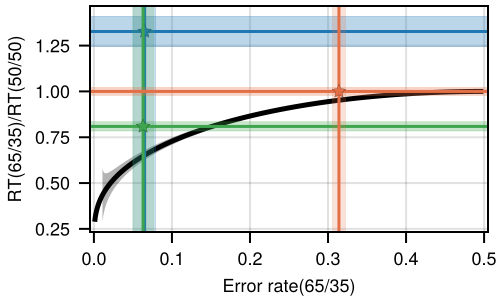

In [30]:
fig = Figure(size=(250, 150), fontsize=9, figure_padding=(3, 6, 3, 3));  #400, 300
begin  
    ax =  Axis(fig[1,1], ylabel="RT(65/35)/RT(50/50)", xlabel="Error rate(65/35)",)#, aspect = AxisAspect(1.4)))#, alignmode = Outside(50)));

    band!(ax, err_vec, t6535t5050.(err_vec) .+ dt.(err_vec), t6535t5050.(err_vec) .- dt.(err_vec), color=(:black, 0.3))
    lines!(ax, err_vec, t6535t5050.(err_vec), linewidth=2.5, color=:black)    
    for group in 1:3
        err_group = errors_data[group];        ebar  = errorbar_data[group];
        RT_group  = RT6535RT5050_data[group];  rtbar = rtbar_data[group];

        vspan!(ax, [err_group-ebar], [err_group+ebar], color=(c[group], 0.2), strokewidth=0.1, strokecolor=c[group])
        hspan!(ax, [RT_group-rtbar], [RT_group+rtbar], color=(c[group], 0.3), strokewidth=0.1, strokecolor=c[group])
        vlines!(ax, [err_group], linewidth=1.5, color=c[group])
        hlines!(ax, [RT_group],  linewidth=1.5, color=c[group])
        scatter!(ax, [err_group], [RT_group], marker=:star5, markersize=8, color=c[group], strokewidth=0.1)
    end
    
    xlims!(ax, -0.005, 0.505); ax.xticks = 0:0.1:0.5;
end
fig